This notebook was a small personal project I worked on to re-familiarize myself with the functions and syntax most commonly used in basic machine learning problems. It was not an exhaustive project, so you will see that the final results are nothing to write home about, but the task was good practice, and as my time series background was never that strong (lack of practice), it helped significantly

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pickle
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import HuberRegressor, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from torch.optim.lr_scheduler import StepLR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

Using TensorFlow backend.
C:\Users\jonat\Anaconda3\envs\python_3p6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jonat\Anaconda3\envs\python_3p6\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jonat\Anaconda3\envs\python_3p6\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jonat\Anaconda3\envs\py

The data in this case is not clean, so the first step is to remove missing/nan values and replace them. The data that was dropped was all concentrated at the beginning/end of the csv, so there was no continuity issue

In [2]:
_missing = ['-200', 'nan','na','-',' ','NaT']
data = pd.read_excel(r"C:\Users\jonat\Documents\Projects\AirQuality\AirQualityUCI\AirQualityUCI.xlsx", na_values=_missing, engine='openpyxl',parse_dates=['Time']).drop(['Unnamed: 15','Unnamed: 16'], axis=1)
data['Time'] = data['Time'].dt.strftime('%H:%M:%S')
data = data.drop(data.index[data.shape[0]-115:])
print(list(data))

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


The next step was to re-arrange the columns and normalize them. The standard (x-xmin)/(xmax-xmin) was calcuated on a per feature basis, to ensure that none of them dominated the optimization

In [3]:
def preprocess(df,*args):
    cols = list(data.columns.values)
    df = df[[c for c in df if c not in args[0] + args[1]] + args[0] + args[1]]
    df = df.fillna(method='ffill')
    return df
    
def norm(col):
    return (col - col.min(axis=0))/(col.max(axis=0) - col.min(axis=0))
    
def normalize(df, cols):
    for col in cols:
        df[col] = norm(df[col])
    return df
    
col_names = ['CO(GT)','NMHC(GT)','C6H6(GT)','NOx(GT)','NO2(GT)']
col_dep = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']
data = preprocess(data, col_names, col_dep)
print("Are there missing values?  ",data.isnull().values.any())
data_n = normalize(data, col_dep)
data_n.head()

Are there missing values?   False


,Date,Time,T,RH,AH,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,2004-03-10,18:00:00,13.60,48.875001,0.757754,2.6,150.0,11.881723,166.0,113.0,0.511849,0.361737,0.311024,0.513040,0.454654
1,2004-03-10,19:00:00,13.30,47.700000,0.725487,2.0,112.0,9.397165,103.0,92.0,0.463196,0.312167,0.360796,0.453125,0.326382
2,2004-03-10,20:00:00,11.90,53.975000,0.750239,2.2,88.0,8.997817,131.0,114.0,0.542011,0.303701,0.346500,0.451214,0.370588
3,2004-03-10,21:00:00,11.00,60.000000,0.786713,2.2,80.0,9.228796,172.0,122.0,0.522980,0.308617,0.326168,0.464366,0.426741
4,2004-03-10,22:00:00,11.15,59.575001,0.788794,1.6,51.0,6.518224,131.0,116.0,0.448833,0.247030,0.374034,0.422212,0.386228


A useful step is to vizualize the features - by doing so, we can see if there are any trends in the data that could be used for time series prediction. In this case, it is quite clear that the data has an upwards or downwards parabolic shape every 24 hour period. This information is useful when we need to start computing lag features

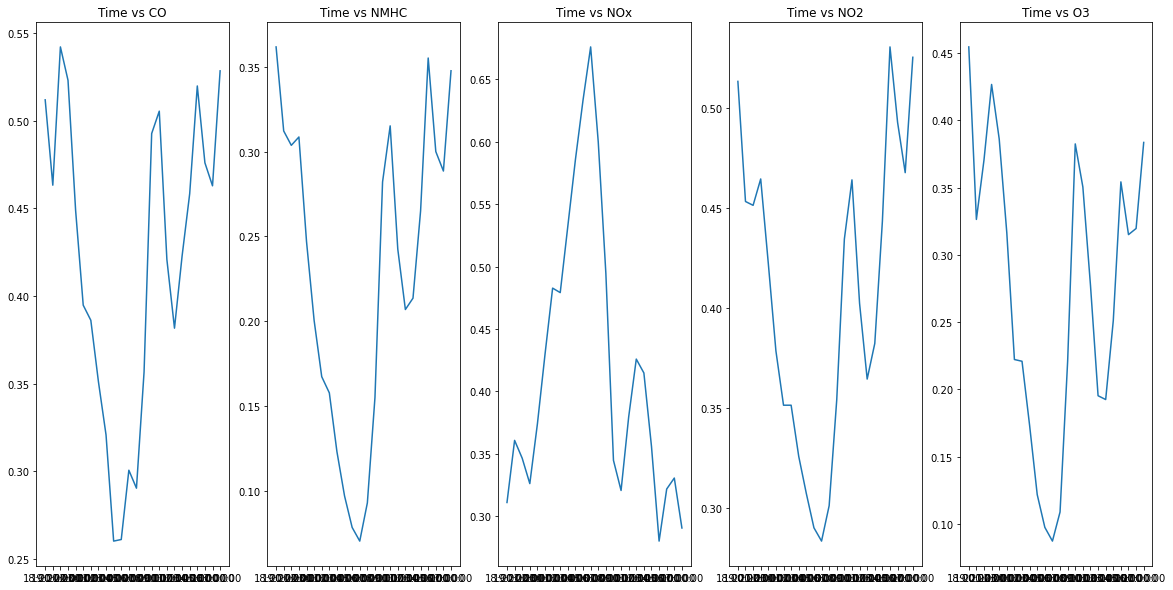

In [4]:
data['sequentialT'] = pd.Series(np.arange(data.shape[0]), index=data.index)
def plot_features(df):
    '''
    a function that plots different independent variables vs the dependent variable
    '''
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20, 10))
    
    ax1.plot(df['Time'].iloc[:24],df['PT08.S1(CO)'].iloc[:24])
    ax1.set_title("Time vs CO")
    ax2.plot(df['Time'].iloc[:24],df['PT08.S2(NMHC)'].iloc[:24])
    ax2.set_title("Time vs NMHC")
    ax3.plot(df['Time'].iloc[:24],df['PT08.S3(NOx)'].iloc[:24])
    ax3.set_title("Time vs NOx")
    ax4.plot(df['Time'].iloc[:24],df['PT08.S4(NO2)'].iloc[:24])
    ax4.set_title("Time vs NO2")
    ax5.plot(df['Time'].iloc[:24],df['PT08.S5(O3)'].iloc[:24])    
    ax5.set_title("Time vs O3")
    plt.show()
plot_features(data)

Once we have visualized the data, we can how start the feature processing. 
Generally, when doing time series prediction, we are trying to predict time t+1 given time t to t0. In this case, the dataset has GT values and sensor values - both seem to follow similar trends. In this case, I tried both using the sensor values to predict GT, as well as the GT values themselves to predict GT @ t+1. Both approaches gave similar results.
In this first example, we generate features at time t to predict time t+1 - this is called a lag 1 feature. Later on, we will use more/longer lag features, but this was a first test.

In [5]:
# Create lagged dataset
def one_lag(cols, data):
    l = []
    n = []
    for i,var in enumerate(cols):
        l.append(list(pd.Series(data[var].values).shift(1))[1:])
        l.append(list(pd.Series(data[var].values))[1:])
        n.append([var +'t-1', var])
    headers = [item for sublist in n for item in sublist]
    df = pd.DataFrame(data=l).transpose()
    df.columns = headers
    return df

df_l1_x = one_lag(col_dep, data)
df_l1_y = one_lag(col_names, data)
print(df_l1_y.head())

   CO(GT)t-1  CO(GT)  NMHC(GT)t-1  NMHC(GT)  C6H6(GT)t-1  C6H6(GT)  \
0        2.6     2.0        150.0     112.0    11.881723  9.397165   
1        2.0     2.2        112.0      88.0     9.397165  8.997817   
2        2.2     2.2         88.0      80.0     8.997817  9.228796   
3        2.2     1.6         80.0      51.0     9.228796  6.518224   
4        1.6     1.2         51.0      38.0     6.518224  4.741012   

   NOx(GT)t-1  NOx(GT)  NO2(GT)t-1  NO2(GT)  
0       166.0    103.0       113.0     92.0  
1       103.0    131.0        92.0    114.0  
2       131.0    172.0       114.0    122.0  
3       172.0    131.0       122.0    116.0  
4       131.0     89.0       116.0     96.0  


Naturally, the next step is to create baseline values to compare our models to. Two baselines were used here - the first is an average rmse baseline, which calculates the loss between each value and the average of each value. This is not recommended for time series usually, but it gave us a good minimum to compare to.
The next baseline was called the persistence algorithm, which compares the value for time t to the value at time t-1. This was the first baseline tried, but what we will see quite quickly is that this approach outperforms nearly all models/feature choices that I could find. 

In [6]:
#baseline - compare GT/y values of lagged data (t-1 to t)
def baseline(d):
    scores = []
    for i in range(int(len(d.columns)/2)):
        scores.append(mean_squared_error(d.iloc[:,2*i], d.iloc[:,2*i+1]))
        print("Persistence baseline score for {} is {}".format(d.columns[2*i+1],scores[i]))
baseline(df_l1_y)

# pure average baseline 
def av_baseline(d):
    scores = []
    for i in range(int(len(d.columns)/2)):
        av = [d.iloc[:,2*i+1].sum(axis=0)/len(d.iloc[:,2*i+1])]*len(d.iloc[:,2*i+1])
        scores.append(mean_squared_error(d.iloc[:,2*i+1],av))
        print("Average baseline score for {} is {}".format(d.columns[2*i+1],scores[i]))
av_baseline(df_l1_y)

Persistence baseline score for CO(GT) is 0.568304649919829
Persistence baseline score for NMHC(GT) is 1838.3646178514164
Persistence baseline score for C6H6(GT) is 17.2561834002917
Persistence baseline score for NOx(GT) is 7351.350431854624
Persistence baseline score for NO2(GT) is 392.2709299839658
Average baseline score for CO(GT) is 2.1605164798104117
Average baseline score for NMHC(GT) is 5372.914801557773
Average baseline score for C6H6(GT) is 57.234882850227564
Average baseline score for NOx(GT) is 42692.11398036303
Average baseline score for NO2(GT) is 2228.7306638831


The run_function is a generic training/testing cross validation function that can be used for any/all sklearn algorithms.
To do the cross validation, the sklearn time series train/test split was employed, which has the following formula 
Train: 0 Test: 1
Train: 0,1 Test: 2
Train: 0,1,2 Test: 3
etc
Note: at the time of writing, sklearn 0.24 was released, which has a parameter called 'test_size' that allows the user to choose the size of the test split. In this case, it might be useful to manually chose the test size, as the periodicity of the readings might affect the predictions. However, conda doesn't claim to see the newest version, so it will be left as a future improvement for this task. 

The previous approach might not be condusive to our data, so we have implemented a few other custom splitting classes
The sliding window method uses sequential sliding windows to do training and testing. It looks something like this 
Train: 1-x Test: x-2x
Train: 2x-3x Text 3x-4x 
etc
This approach ensures that the network focuses on the previous 24 hours only, but only provides it with 24 hours of training data for each set of testing data, which is not ideal. 
The increasing_sliding_window method is essentially the sklearn timeseries split with test_size implemented: it always keeps the test size at a size x, and progressively increases the train window more and more
Train: 1-x Test: x-2x
Train: 1-2x Test: 2x-3x
Train: 1-3x Test: 3x-4x
For both custom cases, the approach ends up dramatically increasing optimization time but not yielding significantly improved results.

In [7]:
class custom_split():
    def __init__(self, alg, window=1):
        self.window = window
        self.alg = alg
    
    def set_window(self,df, lb):
        self.tr_split = []
        self.te_split = []
        idx = np.arange(df.shape[0])
        for i in range(int(df.shape[0]/self.window)):
            if i % 2 == 0:
                self.tr_split.append(np.array(idx[lb*i:self.window*i+self.window]))
            else:
                self.te_split.append(np.array(idx[self.window*i:self.window*i+self.window]))
        if len(self.tr_split) > len(self.te_split):
            self.tr_split.pop()
        self.splits = np.array(list(zip(self.tr_split,self.te_split)))
    
    def sliding_window_split(self, df):
        self.set_window(df,self.window)
        
    def increasing_sliding_window_split(self,df):
        self.set_window(df,0)
        
    def split(self, df):
        if self.alg == 'sliding_window_split':
            self.sliding_window_split(df)
        elif self.alg == 'increasing_sliding_window_split':
            self.increasing_sliding_window_split(df)
        return self.splits
            
c1 = custom_split("sliding_window_split", window=24)


Originally, we would run this run_function function for all values to predict (5 of them) for all functions, and then the best would be chosen. Some of these optimizations take an extensive amount of time, and as my computer is quite old and has limited processing power, it will be used for illustration only.

In [8]:
def run_function(alg, splt, GT_cols, data_x, data_y):
    if splt == 'sklearn':
        tsc = TimeSeriesSplit(n_splits = 10)
    elif splt == 'sliding_window_split':
        tsc = custom_split( "sliding_window_split", window=24)
    model = eval(alg)
    for i in range(int(len(df_l1_y.columns)/2)-4):
        yhat = []
        GT_tr = []
        GT_te = []
        r = []
        for train_index, test_index in tsc.split(data_x):
            preds = []
            x_train, x_test = data_x[data_x.columns[2*i+1]].iloc[train_index], data_x[data_x.columns[2*i+1]].iloc[test_index]   
            y_train, y_test = data_y[GT_cols[i]].iloc[train_index], data_y[GT_cols[i]].iloc[test_index]
            GT_tr.append(y_train)
            GT_te.append(y_test)
            model.fit(np.array(x_train).reshape(-1,1),np.array(y_train))
            preds = model.predict(np.array(x_test).reshape(-1,1))
            yhat.append(preds)
            r.append(mean_squared_error(preds,y_test))
        print("Result for {} algorithm for variable {} is {} \n".format(model,GT_cols[i],sum(r)/len(r)))
        return yhat, GT_te, GT_tr, test_index      

_,_,_,_ = run_function('RandomForestRegressor(n_estimators=200,max_depth=25)', 'sklearn',col_names, df_l1_x, data)
_,_,_,_ = run_function('GradientBoostingRegressor(n_estimators=200,max_depth=25)','sklearn', col_names, df_l1_x, data)
_,_,_,_ = run_function('LinearRegression()','sklearn', col_names, df_l1_x, data)
_,_,_,_ = run_function("MLPRegressor(solver = 'lbfgs', max_iter=250,hidden_layer_sizes=(100,))",'sklearn', col_names, df_l1_x, data)
_,_,_,_ = run_function("KNeighborsRegressor(n_neighbors=7)",'sklearn', col_names, df_l1_x, data)
_,_,_,_ = run_function("SVR(gamma='auto',kernel='poly')",'sklearn', col_names, df_l1_x, data)
_,_,_,_ = run_function("BayesianRidge(alpha_1=1,lambda_1=0.0001)",'sklearn', col_names, df_l1_x, data)

model_linreg_poly = Pipeline([('poly', PolynomialFeatures(degree=2,interaction_only=False)),('linear', LinearRegression(n_jobs=5))])
preds, y_test, y_train, test_index = run_function('model_linreg_poly', "sliding_window_split" ,col_names, df_l1_x.iloc[:,:], data.iloc[:,:])


Result for RandomForestRegressor(max_depth=25, n_estimators=200) algorithm for variable CO(GT) is 1.6997049504160262 

Result for GradientBoostingRegressor(max_depth=25, n_estimators=200) algorithm for variable CO(GT) is 2.030296008934165 

Result for LinearRegression() algorithm for variable CO(GT) is 1.3109037673139823 



C:\Users\jonat\Anaconda3\envs\python_3p6\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Result for MLPRegressor(max_iter=250, solver='lbfgs') algorithm for variable CO(GT) is 1.3124426141541254 

Result for KNeighborsRegressor(n_neighbors=7) algorithm for variable CO(GT) is 1.466311020408163 

Result for SVR(gamma='auto', kernel='poly') algorithm for variable CO(GT) is 1.4634965738814991 

Result for BayesianRidge(alpha_1=1, lambda_1=0.0001) algorithm for variable CO(GT) is 1.310938438883989 

Result for Pipeline(steps=[('poly', PolynomialFeatures()),
                ('linear', LinearRegression(n_jobs=5))]) algorithm for variable CO(GT) is 1.3797029121492528 



As can be seen, the results that are obtained easily beat the average baseline but don't beat the presistence algorithm. In some ways, this makes sense, as the persistence algorithm uses the previous timesteps only, and the data we have isn't smooth, linear or easy to interpret. We can visualize some predictions below

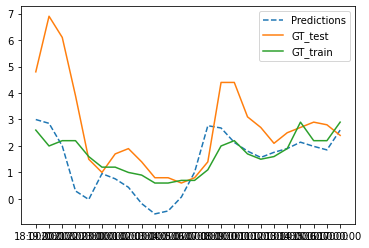

In [9]:
ind = 0
i1 = ind*24
i2 = i1 + 24
plt.plot(data['Time'].iloc[i1:i2], preds[ind],linestyle='dashed')
plt.plot(data['Time'].iloc[i1:i2], y_test[ind])
plt.plot(data['Time'].iloc[i1:i2], y_train[ind])
plt.legend(labels=['Predictions','GT_test','GT_train'])
plt.show()

As seen above, while the predictions vs the GT aren't that close, they're not that far off. It seems like the model is able to approximate the function, but it's still not that accurate.
An additional approach is forecasting. The majority of this code was cut from online, so I don't take credit (either positive or negative =P) 

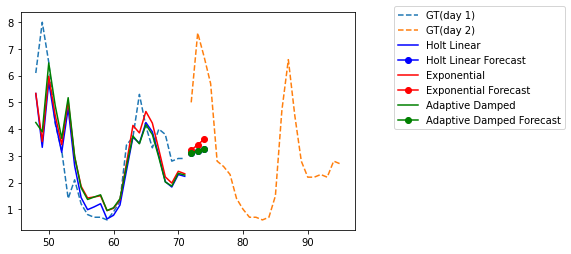

In [10]:
#ind=2 is good for no forecasting
forecast = 3
new_window = 24
ind = 2
i1 = ind*new_window
i2 = i1 + new_window
air = df_l1_y['CO(GT)'].iloc[i1:i2]
fit1 = Holt(air, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
fcast1 = fit1.forecast(forecast).rename("Holt's linear trend")
fit2 = Holt(air, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
fcast2 = fit2.forecast(forecast).rename("Exponential trend")
fit3 = Holt(air, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)
fcast3 = fit3.forecast(forecast).rename("Additive damped trend")
plt.plot(data['sequentialT'].iloc[i1:i2],y_test[ind], linestyle='dashed')
plt.plot(data['sequentialT'].iloc[i1+new_window:i2+new_window],y_test[ind+1], linestyle='dashed')
plt.plot(data['sequentialT'].iloc[i1:i2],fit1.fittedvalues, color='blue')
line2, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(data['sequentialT'].iloc[i1:i2],fit2.fittedvalues, color='red')
line3, = plt.plot(fcast2, marker='o', color='red')
plt.plot(data['sequentialT'].iloc[i1:i2],fit3.fittedvalues, color='green')
line4, = plt.plot(fcast3, marker='o', color='green')
plt.legend(bbox_to_anchor=(1.1, 1.05), labels=['GT(day 1)','GT(day 2)','Holt Linear','Holt Linear Forecast','Exponential','Exponential Forecast','Adaptive Damped','Adaptive Damped Forecast'])
plt.show()

The last option we will try is an LSTM. I won't get into details, but LSTM/RNNs are know to produce good results for sequence prediction, with LSTM's standing out for longer sequences.
As I haven't usec Keras in a long time, I figured it would be good to re-familiarize myself with the API. It's quite simple and intuitive, so a simple notebook implementation will suffice 
Note: instead of cross validation, I have implemented a train/test split (like most NNs). As a result, to properly compare with baselines and other functions, the average baseline was calculated over the test set

In [12]:
np.random.seed(7) 
# split into train and test sets
train_size = int(len(df_l1_x) * 0.75)
test_size = len(df_l1_x) - train_size
train, test = df_l1_x.iloc[0:train_size,:], df_l1_x.iloc[train_size:len(df_l1_x),:]
# we will start with a lookback of 1, and then try longet ones 
look_back = 1
trainX, trainY = np.expand_dims(train.iloc[:,0],axis=1), np.expand_dims(train.iloc[:,1],axis=1)
testX, testY = np.expand_dims(test.iloc[:,0],axis=1),np.expand_dims(test.iloc[:,1],axis=1)

In [14]:
m = RandomForestRegressor()
m.fit(trainX.squeeze().reshape(-1,1),trainY.squeeze().reshape(-1,1))
pr = m.predict(testX.squeeze().reshape(-1,1))
print("result is ",mean_squared_error(pr,testX.squeeze().reshape(-1,1)))
av_baseline(test)

C:\Users\jonat\Anaconda3\envs\python_3p6\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


result is  0.002128547779933759
Average baseline score for PT08.S1(CO) is 0.021998595753342717
Average baseline score for PT08.S2(NMHC) is 0.018653862911307023
Average baseline score for PT08.S3(NOx) is 0.009813098136566837
Average baseline score for PT08.S4(NO2) is 0.01453060629172482
Average baseline score for PT08.S5(O3) is 0.039297088539953035


In [15]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])
#model definition
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) 
#compile, train and predict 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)
pred = model.predict(testX)
r = mean_squared_error(pred, testY)
print("results are ",r)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 14s - loss: 0.0098
Epoch 2/5
 - 13s - loss: 0.0056
Epoch 3/5
 - 14s - loss: 0.0055
Epoch 4/5
 - 14s - loss: 0.0056
Epoch 5/5
 - 14s - loss: 0.0055
results are  0.0041397570200232174


A lookback of 1 seems a bit inadequate, though the plot below seems to show the model matching the predictions well

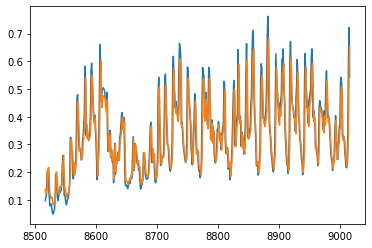

In [439]:
plt.plot(data['sequentialT'].iloc[len(data)-len(testY):][1500:2000], testY[1500:2000])
plt.plot(data['sequentialT'].iloc[len(data)-len(testY):][1500:2000], pred[1500:2000])

We will now redefine the model with a lookback of 24. That is, the LSTM will use the previous 24 features to make the prediction for the 25th one. This means we will need to create lag-24 variables using create_dataset, and then reoptimize the new model 

In [457]:
look_back = 24
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 1])
    return dataX, dataY
X, Y = create_dataset(df_l1_x,look_back=look_back)
train_size = int(len(X) * 0.75)
test_size = len(X) - train_size

trainX, trainY = np.expand_dims(X[:train_size],axis=1), np.expand_dims(Y[:train_size],axis=1)
testX, testY = np.expand_dims(X[train_size:],axis=1),np.expand_dims(Y[train_size:],axis=1)

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=41, batch_size=1, verbose=2)
pred = model.predict(testX)
r = mean_squared_error(pred, testY)
print("results are ",r)

Epoch 1/41
 - 9s - loss: 0.0077
Epoch 2/41
 - 9s - loss: 0.0046
Epoch 3/41
 - 9s - loss: 0.0043
Epoch 4/41
 - 9s - loss: 0.0041
Epoch 5/41
 - 9s - loss: 0.0040
Epoch 6/41
 - 9s - loss: 0.0039
Epoch 7/41
 - 9s - loss: 0.0038
Epoch 8/41
 - 9s - loss: 0.0038
Epoch 9/41
 - 9s - loss: 0.0038
Epoch 10/41
 - 8s - loss: 0.0038
Epoch 11/41
 - 9s - loss: 0.0038
Epoch 12/41
 - 9s - loss: 0.0037
Epoch 13/41
 - 9s - loss: 0.0037
Epoch 14/41
 - 9s - loss: 0.0037
Epoch 15/41
 - 9s - loss: 0.0037
Epoch 16/41
 - 9s - loss: 0.0036
Epoch 17/41
 - 9s - loss: 0.0037
Epoch 18/41
 - 9s - loss: 0.0036
Epoch 19/41
 - 8s - loss: 0.0036
Epoch 20/41
 - 9s - loss: 0.0036
Epoch 21/41
 - 9s - loss: 0.0036
Epoch 22/41
 - 9s - loss: 0.0036
Epoch 23/41
 - 9s - loss: 0.0036
Epoch 24/41
 - 9s - loss: 0.0036
Epoch 25/41
 - 9s - loss: 0.0036
Epoch 26/41
 - 9s - loss: 0.0035
Epoch 27/41
 - 9s - loss: 0.0035
Epoch 28/41
 - 9s - loss: 0.0035
Epoch 29/41
 - 9s - loss: 0.0035
Epoch 30/41
 - 9s - loss: 0.0035
Epoch 31/41
 - 9s -

As we can see, these results are much better. There are a lot of possible improvements to get better performance, but as noted, this is meant as a refresher only, and will be left as is